# Generating Synthetic Validation Time-Frequency Representation (TFR) Data
This script generates synthetic time-frequency representation (TFR) data to validate the NeuroCluster method using a dataset with a known ground truth. Users can modify parameters as needed to create variations of the synthetic test data.

The output is an [```mne.time_frequency.EpochsTFR``` object](https://mne.tools/1.8/generated/mne.time_frequency.EpochsTFR.html), saved as a ```.fif``` file. The data has a four-dimensional structure:

(n_trials, n_channels, n_freqs, n_times)

This structured format enables controlled validation of NeuroCluster's performance under known conditions.



In [1]:
# load relevant packages 
import numpy as np
import mne
import pandas as pd
from scipy.stats import norm

# define an output directory to save the synthetic data 
output_directory = '/path/to/output/directory/'

In [ ]:
# Define parameters (timing, frequency, number of trials, and channels)
# These parameters can be adjusted as needed
times = np.linspace(-1, 1, 500)  # 500 time points from -1s to 1s
freqs = np.logspace(*np.log10([2, 200]), num=30) # 30 frequencies from 2Hz to 200Hz
n_trials = 100
n_channels = 1

# Create baseline noise - we do this because we want to simulate a TFR with some baseline noise
np.random.seed(42)
data = np.random.randn(n_trials, len(freqs), len(times)) * 0.1  # Random noise

# Generate 'expected value' metadata with values from a uniform distribution - we do this to simulate an example behavioral regressor that is continous. 
expected_value = np.linspace(0, 1, n_trials)  # Expected values from 0 to 1

# Add power increase in 70-200 Hz at 0.5-0.6s based on 'expected value' - we do this to simulate a TFR with a power increase in a specific frequency band and time window associated with increases in expected value. NeuroCluster should identify this cluster as a validation for the method. 
time_mask = (times >= 0.5) & (times <= 0.6)
freq_mask = freqs >= 70

# Create a Gaussian-shaped power increase - we do this to simulate a TFR with a Gaussian-shaped power increase in a specific frequency band and time window.
# The Gaussian is centered at 0.55s with a standard deviation of 0.05s
# and the frequency band is 70-200 Hz.
time_profile = norm.pdf(times, loc=0.55, scale=0.05)  # Peak at 0.55s, std=0.05
freq_profile = np.linspace(0.5, 1, sum(freq_mask))[:, None]  # Linearly increasing power

# Apply power increase proportional to 'expected value' - 
for i in range(n_trials):
    data[i, freq_mask, :] += (freq_profile * time_profile[None, :]) * 2 * expected_value[i]  # Scale by expected value

# Reshape data to 4D (n_trials, n_channels, n_freqs, n_times)
data = data[:, np.newaxis, :, :]

# Create MNE TFR object
info = mne.create_info(ch_names=['synthetic_channel'], sfreq=500, ch_types=['eeg'])
tfr = mne.time_frequency.EpochsTFR(info, data, times, freqs, n_trials, method='custom')

# Assign metadata as a DataFrame
tfr.metadata = pd.DataFrame({'expected_value': expected_value})

# Plot two TFRs - separately for high and low expected values
high_expected = tfr.metadata['expected_value'] > 0.5
low_expected = tfr.metadata['expected_value'] <= 0.5
tfr_high = tfr.copy()
tfr_high.data = tfr.data[high_expected]
tfr_low = tfr.copy()
tfr_low.data = tfr.data[low_expected]
# Plotting
tfr_high.average().plot([0], title='High Expected Value')
tfr_low.average().plot([0], title='Low Expected Value')
# Show the plots
plt.show()


In [9]:
# save the TFR object to a file
tfr.save(f'{output_directory}/synthetic_validation_tfr.fif')

Reading /Users/christinamaher/Documents/GitHub/NeuroCluster/data/synthetic_validation_tfr_data/synthetic_validation_tfr.fif ...
Adding metadata with 1 columns
No baseline correction applied


/var/folders/5p/bctklsps5kgb5fk5s1nygs3m0000gn/T/ipykernel_23956/3224597004.py:5: RuntimeWarning: This filename (/Users/christinamaher/Documents/GitHub/NeuroCluster/data/synthetic_validation_tfr_data/synthetic_validation_tfr.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs(f'/Users/christinamaher/Documents/GitHub/NeuroCluster/data/synthetic_validation_tfr_data/synthetic_validation_tfr.fif')[0]


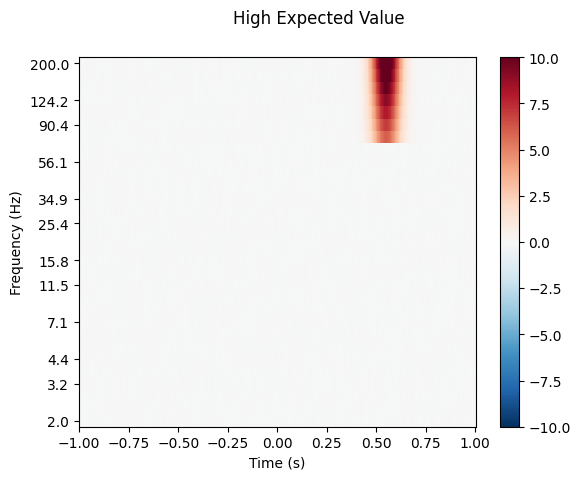

No baseline correction applied


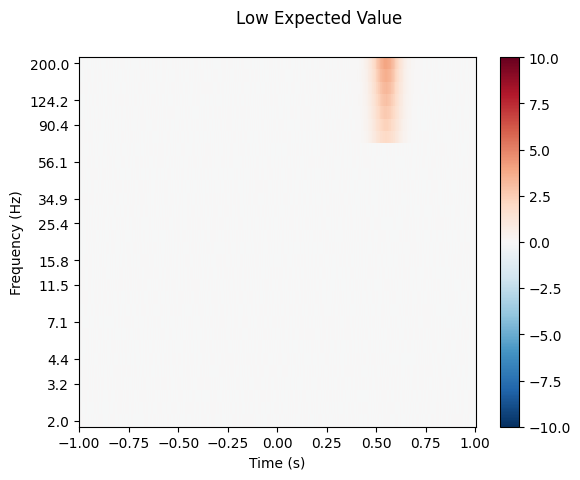

In [6]:
import matplotlib.pyplot as plt
import mne

# Load TFR object from file
tfr = mne.time_frequency.read_tfrs(f'/Users/christinamaher/Documents/GitHub/NeuroCluster/data/synthetic_validation_tfr_data/synthetic_validation_tfr.fif')[0]

# Plot two TFRs - separately for high and low expected values
high_expected = tfr.metadata['expected_value'] > 0.5
low_expected = tfr.metadata['expected_value'] <= 0.5
tfr_high = tfr.copy()
tfr_high.data = tfr.data[high_expected]
tfr_low = tfr.copy()
tfr_low.data = tfr.data[low_expected]

# Create figure for high expected values
fig_high, ax_high = plt.subplots()
tfr_high.average().plot([0], title='High Expected Value', vmin=-10, vmax=10, axes=ax_high)
fig_high.savefig('high_expected_value_plot.pdf')

# Create figure for low expected values
fig_low, ax_low = plt.subplots()
tfr_low.average().plot([0], title='Low Expected Value', vmin=-10, vmax=10, axes=ax_low)
fig_low.savefig('low_expected_value_plot.pdf')

# Show the plots
plt.show()